##**Определение проблемы** 
Продвижение онлайн-курсов Нетологии осуществляется без применения моделей машинного обучения. Следующий этап развития продвижения курсов - попытка попасть в индивидуальные пожелания клиентов, улучшив клиентский опыт и увеличив выручку. Для этого был выбран подход NBO (Next Best Offer): перед рассылкой коммуникаций необходимо понимать, какой из доступных курсов максимизирует вероятность отклика покупателя.

### **Задача**
Разработать модель, подбирающую наиболее актуальный курс для клиента

### **Метрика**
В качестве метрики выступает взвешенная сумма Recall и Precision по следующей формуле:
𝑅𝑒𝑠𝑢𝑙𝑡 = 0. 2 * 𝑅𝑒𝑐𝑎𝑙𝑙 + 0. 8 * 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛


## Загрузим данные и нужные библиотеки

In [216]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/Projects/Orenburg/'

In [217]:
#Объединим тренировочный и тестовый сеты с целью одновременной обработки
train = pd.read_csv(PATH+"train.csv")
test = pd.read_csv(PATH+"test.csv")
df =  pd.concat([train, test], ignore_index=True)

## Рассмотрим датасет поближе

In [156]:
df.head(3)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,...,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,9/30/2020,6694527,1469,8/26/2020,163.0,0.0,1.0,0.0,...,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,0.0
1,89385,NaN,6/30/2021,6712877,1392,8/5/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,47931,NaN,2/28/2021,6659444,376,6/20/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [157]:
df.shape

(284997, 59)

In [158]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,284997.0,1.424980e+05,82271.691672,0.000,7.124900e+04,1.424980e+05,2.137470e+05,2.849960e+05
age_indicator,226671.0,2.041185e+01,11.501574,1.000,1.000000e+01,2.000000e+01,3.000000e+01,4.000000e+01
student_id,284997.0,6.672630e+06,881633.675792,492.000,6.652595e+06,6.814381e+06,7.050444e+06,8.010481e+06
program_id,284997.0,9.632759e+02,547.224341,12.000,4.900000e+02,9.240000e+02,1.360000e+03,2.714000e+03
spent_time_total,122996.0,7.809595e+01,115.630470,0.000,9.000000e+00,3.800000e+01,9.700000e+01,3.111000e+03
spent_time_to_complete_hw,60513.0,-4.957612e-05,0.007041,-1.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
completed_hw,139080.0,1.334872e+00,1.976013,0.000,0.000000e+00,0.000000e+00,2.000000e+00,3.400000e+01
failed_hw,139080.0,2.444636e-02,0.740307,0.000,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+02
reworked_hw,139080.0,5.854515e+00,15.861389,0.000,0.000000e+00,0.000000e+00,0.000000e+00,7.210000e+02
interacted_hw,139080.0,3.437928e+00,2.048457,2.000,2.000000e+00,2.000000e+00,4.000000e+00,3.800000e+01


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284997 entries, 0 to 284996
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         284997 non-null  int64  
 1   age_indicator              226671 non-null  float64
 2   month_id                   284997 non-null  object 
 3   student_id                 284997 non-null  int64  
 4   program_id                 284997 non-null  int64  
 5   carts_created_at           284997 non-null  object 
 6   spent_time_total           122996 non-null  float64
 7   spent_time_to_complete_hw  60513 non-null   float64
 8   completed_hw               139080 non-null  float64
 9   failed_hw                  139080 non-null  float64
 10  reworked_hw                139080 non-null  float64
 11  interacted_hw              139080 non-null  float64
 12  avg_hw_mark                63405 non-null   float64
 13  test_with_good_mark        13

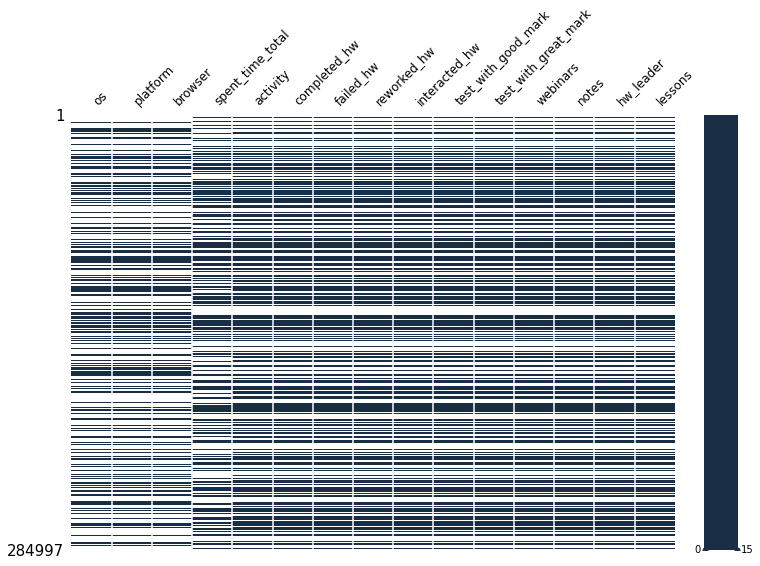

In [218]:
import missingno 

missingno.matrix(df[['os', 'platform', 'browser', 
                     'spent_time_total', 'activity', 'completed_hw',
                     'failed_hw', 'reworked_hw', 'interacted_hw',
                     'test_with_good_mark', 'test_with_great_mark',
                     'webinars', 'notes', 'hw_leader', 'lessons'
                     ]],figsize=(12,8), fontsize=12, color=(0.10, 0.18, 0.27)) #color in misingno is in RGB Percent
plt.show()

Очевидно не получится заполнить пропуски на основании данных из других колонок - пропуски слишком скоррелированны

In [219]:
percent_missing = (df.isnull().sum().sort_values(ascending = False) * 100 / len(df)).round(2)  

percent_missing=pd.DataFrame(percent_missing)
bad_columns=percent_missing[percent_missing.values>50].index
df = df.drop(columns=bad_columns, axis = 1) # уберем все колонки, в которых пропущенных значений больше 50%

percent_missing 

,0
bought_avg_duration,94.86
country,93.56
city,93.24
p_avg_duration,93.21
feedback_avg_d2,92.62
feedback_avg_d5,92.11
avg_quiz_result,91.86
p_total_duration,91.73
p_total_calls,91.73
p_missed_calls,91.73


Заменим все пропуски в данных

In [225]:

df['age_indicator'] = df['age_indicator'].fillna(df['age_indicator'].mean())
df['gender'] = df['gender'].fillna(df['gender'].max())
df['communication_type'] = df['communication_type'].fillna('order')


## Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

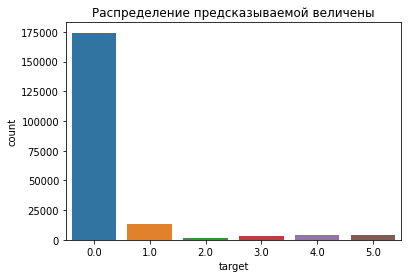

In [ ]:
sns.countplot(x = "target" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение возраста')

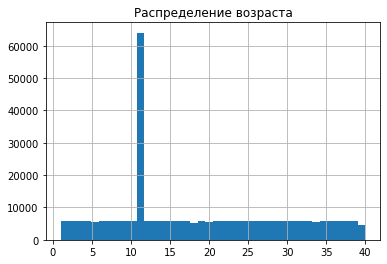

In [ ]:
max(df["age_indicator"])

40.0

In [222]:
df.columns

Index(['id', 'age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'payment_type', 'promo', 'price', 'communication_type',
       'auto_payment', 'ABC', 'gender', 'target'],
      dtype='object')

Взглянем на несколько величин сразу

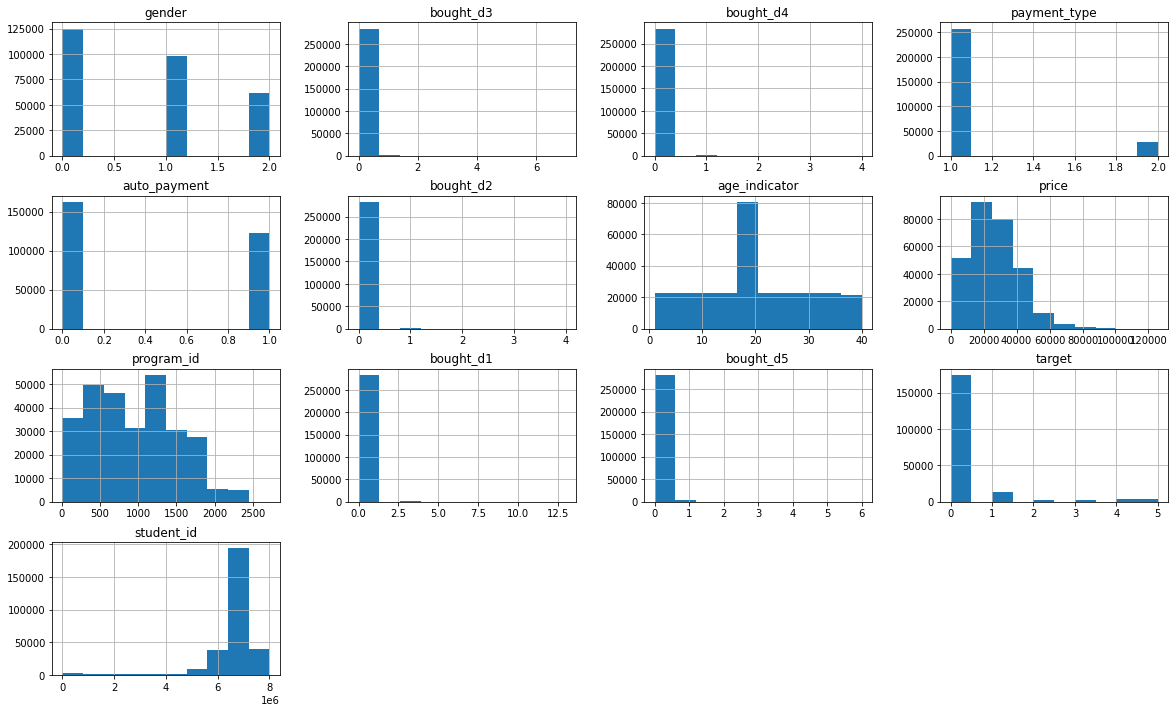

In [224]:
features = list(set(['age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'payment_type', 'promo', 'price', 'communication_type',
       'auto_payment', 'ABC', 'gender', 'target']))

_ = df[features].hist(figsize=(20,12))

## Feature engineering

In [226]:
df.carts_created_at=pd.to_datetime(df.carts_created_at)
df.month_id = pd.to_datetime(df.month_id)

df['date_diff']=( df.month_id-df.carts_created_at) # посчитаем разницу между созданием корзины клиентом и датой среза
df.date_diff = df.date_diff.apply(lambda x: x.days)

df['day'] = df.carts_created_at.dt.day
df['weekday'] = df.carts_created_at.dt.weekday
df['dayofyear'] = df.carts_created_at.dt.dayofyear
df['month'] = df.carts_created_at.dt.month
df['year'] = df.carts_created_at.dt.year
# df['season'] = df['month'].apply(lambda x: x // 3)
# df['week_of_month'] = df.carts_created_at.apply(lambda d: (d.day-1) // 7 + 1)

In [227]:
# дополним категорийные признаки частотой, с которой они встречаются
fre_list = ['month_id', 'program_id', 'student_id', 'payment_type', 'communication_type', 'ABC', 'promo', 'gender', 'age_indicator']

for i in fre_list:
  newname = i + '_freq'
  df[newname] = df.groupby([i])[i].transform('count')
  df[newname] = df[newname]/df.shape[0]*df[i].unique().size
  df[newname] = df[newname].apply(lambda x: np.log(x+1))

In [228]:
# дополним статистику по датам

dates=['day', 'weekday', 'dayofyear', 'month', 'year']

df['dates_sum'] =df[dates].sum(axis=1)
df['dates_std'] =df[dates].std(axis=1)
df['dates_mean'] =df[dates].mean(axis=1)
df['dates_median'] =df[dates].median(axis=1)

In [229]:
# дополним статистику по клиентам

person=['age_indicator', 'gender', 'payment_type']

df['person_sum'] =df[person].sum(axis=1)
df['person_std'] =df[person].std(axis=1)
df['person_mean'] =df[person].mean(axis=1)
df['person_median'] =df[person].median(axis=1)

In [230]:
# кодируем категорийные признаки

df.promo = pd.Categorical(df.promo)
df.promo.astype('category').cat.codes
df.promo = df.promo.cat.codes

df.communication_type= pd.Categorical(df.communication_type)
df.communication_type.astype('category').cat.codes
df.communication_type = df.communication_type.cat.codes



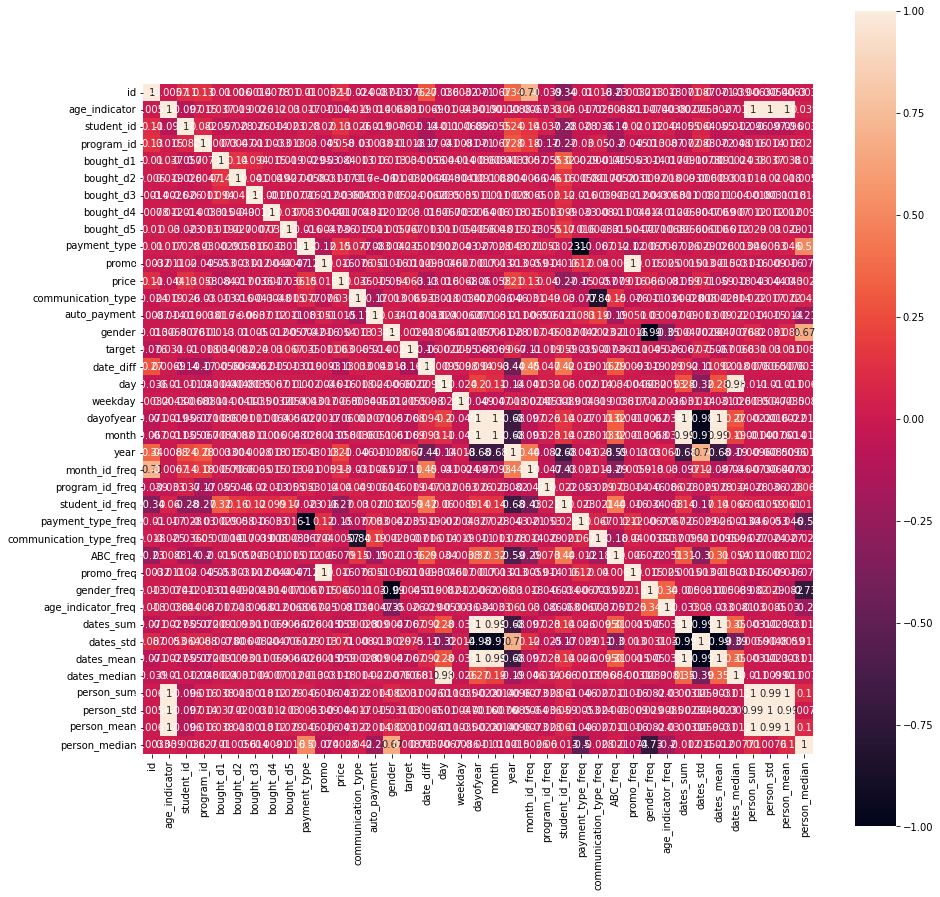

In [169]:
# Посмотрим на корреляцию признаков

plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df.corr(), square = True, annot=True)

## Выделим выборки

In [231]:

df_train = df.loc[df.target.notnull()]
df_test = df.loc[df.target.isnull()]

Уберем категорийные признаки

In [232]:
X = df_train.drop(columns=[
                           "target", 'id', 
                           'month_id', 'carts_created_at', 'ABC'
                           ], axis = 1)
y = df_train["target"]
y = y.astype('int8')

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [234]:
#ограничим максимальное число признаков используемое каждым деревом, чтобы "лес" рос вширь
clf = RandomForestClassifier(random_state=0, max_features=12) 

In [235]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=12, random_state=0)

## Оценка точности

In [236]:
pred = clf.predict(X_test)

In [237]:
0.2* recall_score(y_test, pred, average='macro') + 0.8* precision_score(y_test, pred, average='macro')

0.9298500946178012

In [239]:
def plot_feature_importance(importance,names,model_type):
  """
  Функция отображающая на графике значимость признаков в порядке убывания значимости
  """

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

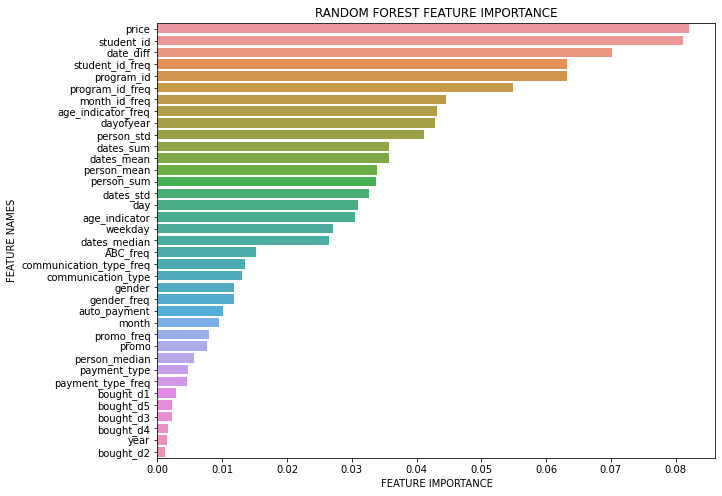

In [240]:
plot_feature_importance(clf.feature_importances_, X.columns,'RANDOM FOREST')

## Подготовка ответов к отправке

In [241]:
answers = pd.read_csv(f'{PATH}sample_solution.csv')

In [242]:
clf.fit(X, y)

RandomForestClassifier(max_features=12, random_state=0)

In [243]:
X_test = df_test.drop(columns=["target", 'id', 
                               'month_id', 'carts_created_at', 'ABC',
                               ], axis=1)

In [244]:
answers.target = clf.predict(X_test)

In [245]:
answers.head()

,id,target
0,77551,0
1,227812,0
2,103035,0
3,260943,0
4,134611,0


In [246]:
answers.target.value_counts()

0    74642
1     5588
4     1430
5     1379
3     1278
2      680
Name: target, dtype: int64

In [247]:
answers.to_csv(f'{PATH}submission-oburg-05-08-final.csv', index=False) 